# CREATING THE NORTH AMERICA SHAPE

In [242]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import mapclassify
from matplotlib.patches import Patch
from pathlib import Path
from rapidfuzz import process, fuzz
from shapely.geometry import Point


In [243]:
# Set base project path
base_path = Path("C:/Users/juami/Dropbox/RAships/2-Folklore-Nathan-Project/EA-Maps-Nathan-project/Measures_work")

# Set file paths
northAmerica_path = base_path / "maps" / "raw" / "Murdock_maps" / "_murdock_americas" / "murdock_north_america.shp"

EA_csv_path = base_path / "data" / "raw" / "ethnographic_atlas" / "ethnographic_atlas_east_siberia_wes_vfinal.csv"

export_path = base_path / "maps" / "interim" / "pre_columbian_update" / "north_america"

## Cleaning the NA-shapefile and the EA-df

In [244]:
# Read the shapefiles and CSV files
northAmerica_shape = gpd.read_file(northAmerica_path)

EA_df = pd.read_csv(EA_csv_path)

northAmerica_shape.head()

,ethnicity,Shape_Leng,Shape_Area,geometry
0,Abnaki,24.521662,13.082665,"POLYGON ((-71.139 46.861, -70.562 47.093, -70...."
1,Acaxee,7.126570,2.395980,"POLYGON ((-106.38 23.88, -106.47 24.125, -106...."
2,Achomawi,5.083474,1.394125,"POLYGON ((-122.35 41.101, -122.27 41.154, -122..."
3,Acolapissa,21.344068,1.949386,"POLYGON ((-91.217 29.857, -91.182 30.026, -91...."
4,Acoma,2.603583,0.488846,"POLYGON ((-107.88 35.197, -107.86 35.279, -107..."


In [245]:
northAmerica_shape['ethnicity_clean'] = (
    northAmerica_shape['ethnicity']
    .str.lower()
    .str.replace(r'[.\s]', '', regex=True)  # removes periods and spaces
)

northAmerica_shape.head()

,ethnicity,Shape_Leng,Shape_Area,geometry,ethnicity_clean
0,Abnaki,24.521662,13.082665,"POLYGON ((-71.139 46.861, -70.562 47.093, -70....",abnaki
1,Acaxee,7.126570,2.395980,"POLYGON ((-106.38 23.88, -106.47 24.125, -106....",acaxee
2,Achomawi,5.083474,1.394125,"POLYGON ((-122.35 41.101, -122.27 41.154, -122...",achomawi
3,Acolapissa,21.344068,1.949386,"POLYGON ((-91.217 29.857, -91.182 30.026, -91....",acolapissa
4,Acoma,2.603583,0.488846,"POLYGON ((-107.88 35.197, -107.86 35.279, -107...",acoma


In [246]:
EA_df['EA_v107_clean'] = (
    EA_df['v107']
    .str.lower()
    .str.replace(r'[.\s]', '', regex=True)  # removes periods and spaces
)

EA_df['EA_v107_clean'] = EA_df['EA_v107_clean'].replace('greenland', 'westgreenlandeskimo')
EA_df['EA_v107_clean'] = EA_df['EA_v107_clean'].replace('baffinlan', 'baffilandeskimo')
EA_df['EA_v107_clean'] = EA_df['EA_v107_clean'].replace('labradore', 'labradoreskimo')

EA_df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v99,v107,v100,v102,v104,v106,v112,v113,v114,EA_v107_clean
0,0.0,1.0,0.0,8.0,1.0,1,8,2,2,3,...,13,ABABDA. .,0.0,1920.0,24,34,8.0,0.0,95.0,ababda
1,0.0,2.0,1.0,1.0,6.0,1,8,5,5,9,...,3,ABARAMBO.,0.0,1890.0,4,27,6.0,0.0,72.0,abarambo
2,2.0,1.0,0.0,1.0,6.0,1,5,2,2,9,...,0,ABELAM. .,0.0,1930.0,-4,145,3.0,0.0,241.0,abelam
3,2.0,6.0,1.0,1.0,0.0,1,8,2,2,3,...,0,ABIPON. .,0.0,1800.0,-29,-61,1.0,0.0,392.0,abipon
4,1.0,0.0,0.0,6.0,3.0,4,8,8,2,9,...,0,ABKHAZ .,0.0,1880.0,43,41,0.0,0.0,133.0,abkhaz


## Making the fuzzy match between names (threshold score 85)

In [247]:
# Create a list of unique v107 values to match against
v107_values = EA_df['EA_v107_clean'].dropna().unique().tolist()

# Function to get best fuzzy match for one value
def get_best_match(value, choices, scorer=fuzz.ratio, threshold=85):
    if pd.isna(value):
        return None, 0
    match, score, _ = process.extractOne(value, choices, scorer=scorer)
    return (match, score) if score >= threshold else (None, score)

# Apply matching to each row in the shape file
northAmerica_shape[['matched_EA_v107', 'match_score']] = northAmerica_shape['ethnicity_clean'].apply(
    lambda x: pd.Series(get_best_match(x, v107_values))
)

northAmerica_shape[['ethnicity', 'ethnicity_clean', 'matched_EA_v107', 'match_score']].head()

,ethnicity,ethnicity_clean,matched_EA_v107,match_score
0,Abnaki,abnaki,abnaki,100.000000
1,Acaxee,acaxee,NaN,57.142857
2,Achomawi,achomawi,achomawi,100.000000
3,Acolapissa,acolapissa,NaN,63.157895
4,Acoma,acoma,acoma,100.000000


In [248]:
# Count NaNs in 'matched_v107'
num_nans = northAmerica_shape['matched_EA_v107'].isna().sum()

# Total number of rows
total_rows = len(northAmerica_shape)

# Proportion of NaNs
nan_proportion = num_nans / total_rows

print(f"Number of Obs: {total_rows}")
print(f"Number of NaNs in matched_v107: {num_nans}")
print(f"Proportion of NaNs: {nan_proportion:.2%}")

Number of Obs: 277
Number of NaNs in matched_v107: 102
Proportion of NaNs: 36.82%


## Creating the EA spatial GDF (XY points)

,EA_v107_clean,v107,geometry
0,ababda,ABABDA. .,POINT (34 24)
1,abarambo,ABARAMBO.,POINT (27 4)
2,abelam,ABELAM. .,POINT (145 -4)
3,abipon,ABIPON. .,POINT (-61 -29)
4,abkhaz,ABKHAZ .,POINT (41 43)


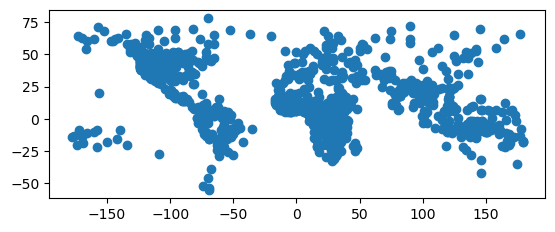

In [249]:
# Step 1: Create geometry column from longitude and latitude
geometry = [Point(xy) for xy in zip(EA_df['v106'], EA_df['v104'])]

# Step 2: Create a GeoDataFrame
EA_gdf = gpd.GeoDataFrame(EA_df, geometry=geometry)

# Step 3: Set the coordinate reference system (CRS) to WGS84 (standard lat/lon)
EA_gdf.set_crs(epsg=4326, inplace=True)

EA_gdf = EA_gdf[["EA_v107_clean", "v107", "geometry"]]

EA_gdf.plot()
EA_gdf.head()


In [250]:
# Step 1: Get all unique values to exclude (the ones that already matched)
values_to_exclude = northAmerica_shape['matched_EA_v107'].dropna().unique()

# Step 2: Filter EA_gdf to keep only rows that are NOT in that list
EA_gdf_filtered = EA_gdf[~EA_gdf['EA_v107_clean'].isin(values_to_exclude)]

EA_gdf_filtered.head()


,EA_v107_clean,v107,geometry
0,ababda,ABABDA. .,POINT (34 24)
1,abarambo,ABARAMBO.,POINT (27 4)
2,abelam,ABELAM. .,POINT (145 -4)
3,abipon,ABIPON. .,POINT (-61 -29)
4,abkhaz,ABKHAZ .,POINT (41 43)


## Making the spatial merge for non matched ethnicities

In [251]:
northAmerica_EA_nearest = gpd.sjoin_nearest(
    northAmerica_shape,   # polygons (left)
    EA_gdf_filtered,               # points (right)
    how="left",
    distance_col="distance_to_point"  # Optional: adds distance column
)

northAmerica_EA_nearest.tail()

c:\Users\juami\anaconda3\envs\geo\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,ethnicity,Shape_Leng,Shape_Area,geometry,ethnicity_clean,matched_EA_v107,match_score,index_right,EA_v107_clean,v107,distance_to_point
273,Zacalteco,10.311888,5.806948,"POLYGON ((-104.08 26.302, -103.94 26.214, -103...",zacalteco,NaN,82.352941,231,chichimec,CHICHIMEC,2.006325
274,Zapotec,9.138888,2.529817,"POLYGON ((-97.175 15.904, -97.121 16.135, -97....",zapotec,zapotec,100.000000,743,mixe,MIXE. . .,0.093236
275,Zoque,8.152896,2.211421,"POLYGON ((-95.653 17.39, -95.524 17.434, -95.2...",zoque,NaN,54.545455,743,mixe,MIXE. . .,0.000000
276,Zuni,2.310273,0.369743,"POLYGON ((-109.2 35.165, -109.25 35.282, -109....",zuni,zuni,100.000000,957,santaana,SANTAANA.,1.405423
276,Zuni,2.310273,0.369743,"POLYGON ((-109.2 35.165, -109.25 35.282, -109....",zuni,zuni,100.000000,602,laguna,LAGUNA. .,1.405423


## Creating the final ethnicity variable 
### (first matched names then spatial match for units within the Murdock polygons / not including more than one within points)

In [252]:
northAmerica_EA_nearest['final_ethnicity'] = northAmerica_EA_nearest['matched_EA_v107']

# Fill missing values with EA_v107_clean only if distance_to_point is 0
mask = (northAmerica_EA_nearest['matched_EA_v107'].isna()) & (northAmerica_EA_nearest['distance_to_point'] == 0)
northAmerica_EA_nearest.loc[mask, 'final_ethnicity'] = northAmerica_EA_nearest.loc[mask, 'EA_v107_clean']

northAmerica_EA_nearest.tail()

,ethnicity,Shape_Leng,Shape_Area,geometry,ethnicity_clean,matched_EA_v107,match_score,index_right,EA_v107_clean,v107,distance_to_point,final_ethnicity
273,Zacalteco,10.311888,5.806948,"POLYGON ((-104.08 26.302, -103.94 26.214, -103...",zacalteco,NaN,82.352941,231,chichimec,CHICHIMEC,2.006325,NaN
274,Zapotec,9.138888,2.529817,"POLYGON ((-97.175 15.904, -97.121 16.135, -97....",zapotec,zapotec,100.000000,743,mixe,MIXE. . .,0.093236,zapotec
275,Zoque,8.152896,2.211421,"POLYGON ((-95.653 17.39, -95.524 17.434, -95.2...",zoque,NaN,54.545455,743,mixe,MIXE. . .,0.000000,mixe
276,Zuni,2.310273,0.369743,"POLYGON ((-109.2 35.165, -109.25 35.282, -109....",zuni,zuni,100.000000,957,santaana,SANTAANA.,1.405423,zuni
276,Zuni,2.310273,0.369743,"POLYGON ((-109.2 35.165, -109.25 35.282, -109....",zuni,zuni,100.000000,602,laguna,LAGUNA. .,1.405423,zuni


In [253]:
# Erasing duplicates and unnecessary columns
northAmerica_shape_unique = northAmerica_EA_nearest.drop_duplicates(subset=['ethnicity', 'final_ethnicity'])
northAmerica_shape_unique = northAmerica_shape_unique.drop(columns=['EA_v107_clean', 'v107','index_right'], errors='ignore')

northAmerica_shape_unique.tail()

,ethnicity,Shape_Leng,Shape_Area,geometry,ethnicity_clean,matched_EA_v107,match_score,distance_to_point,final_ethnicity
272,Yurok,1.916343,0.211345,"POLYGON ((-124.27 40.708, -124.25 40.733, -124...",yurok,yurok,100.000000,0.604275,yurok
273,Zacalteco,10.311888,5.806948,"POLYGON ((-104.08 26.302, -103.94 26.214, -103...",zacalteco,NaN,82.352941,2.006325,NaN
274,Zapotec,9.138888,2.529817,"POLYGON ((-97.175 15.904, -97.121 16.135, -97....",zapotec,zapotec,100.000000,0.093236,zapotec
275,Zoque,8.152896,2.211421,"POLYGON ((-95.653 17.39, -95.524 17.434, -95.2...",zoque,NaN,54.545455,0.000000,mixe
276,Zuni,2.310273,0.369743,"POLYGON ((-109.2 35.165, -109.25 35.282, -109....",zuni,zuni,100.000000,1.405423,zuni


In [254]:
#Creating the total number of duplicates within the same ethnicity_clean 

# Step 1: Filter where distance is 0
distance_zero_mask = northAmerica_shape_unique['distance_to_point'] == 0

# Step 2: Count how many times each ethnicity_clean appears with distance == 0
ethnicity_counts = (
    northAmerica_shape_unique[distance_zero_mask]
    .groupby('ethnicity_clean')
    .size()
    .rename('distance_zero_dups')
)

# Step 3: Map the count back to the full DataFrame
northAmerica_shape_unique['distance_zero_dups'] = northAmerica_shape_unique['ethnicity_clean'].map(ethnicity_counts).fillna(0).astype(int)

northAmerica_shape_unique.tail()


,ethnicity,Shape_Leng,Shape_Area,geometry,ethnicity_clean,matched_EA_v107,match_score,distance_to_point,final_ethnicity,distance_zero_dups
272,Yurok,1.916343,0.211345,"POLYGON ((-124.27 40.708, -124.25 40.733, -124...",yurok,yurok,100.000000,0.604275,yurok,0
273,Zacalteco,10.311888,5.806948,"POLYGON ((-104.08 26.302, -103.94 26.214, -103...",zacalteco,NaN,82.352941,2.006325,NaN,0
274,Zapotec,9.138888,2.529817,"POLYGON ((-97.175 15.904, -97.121 16.135, -97....",zapotec,zapotec,100.000000,0.093236,zapotec,0
275,Zoque,8.152896,2.211421,"POLYGON ((-95.653 17.39, -95.524 17.434, -95.2...",zoque,NaN,54.545455,0.000000,mixe,1
276,Zuni,2.310273,0.369743,"POLYGON ((-109.2 35.165, -109.25 35.282, -109....",zuni,zuni,100.000000,1.405423,zuni,0


In [255]:
#Looking at duplicates
duplicates_df = northAmerica_shape_unique[northAmerica_shape_unique['distance_zero_dups'] > 1]
duplicates_df.head()

,ethnicity,Shape_Leng,Shape_Area,geometry,ethnicity_clean,matched_EA_v107,match_score,distance_to_point,final_ethnicity,distance_zero_dups
65,Coyotero,9.387071,5.227553,"POLYGON ((-111.27 33.515, -111.28 33.667, -111...",coyotero,NaN,61.538462,0.0,keweyipay,2
65,Coyotero,9.387071,5.227553,"POLYGON ((-111.27 33.515, -111.28 33.667, -111...",coyotero,NaN,61.538462,0.0,wapache,2
170,Olamentke,3.089630,0.214920,"POLYGON ((-122.95 38.163, -122.81 38.217, -122...",olamentke,NaN,71.428571,0.0,lakemiwok,2
170,Olamentke,3.089630,0.214920,"POLYGON ((-122.95 38.163, -122.81 38.217, -122...",olamentke,NaN,71.428571,0.0,spomo,2
177,Paiute,23.268145,15.011145,"POLYGON ((-117.47 35.914, -116.74 35.989, -116...",paiute,NaN,61.538462,0.0,chemehuev,4


In [256]:
# Replacing the final_ethnicity of the duplicates with NaN and dropping them

northAmerica_shape_unique.loc[
    northAmerica_shape_unique['distance_zero_dups'] > 1,
    'final_ethnicity'
] = np.nan

northAmerica_shape_unique = northAmerica_shape_unique.drop_duplicates(subset=['ethnicity', 'final_ethnicity'])

northAmerica_shape_unique.tail()

,ethnicity,Shape_Leng,Shape_Area,geometry,ethnicity_clean,matched_EA_v107,match_score,distance_to_point,final_ethnicity,distance_zero_dups
272,Yurok,1.916343,0.211345,"POLYGON ((-124.27 40.708, -124.25 40.733, -124...",yurok,yurok,100.000000,0.604275,yurok,0
273,Zacalteco,10.311888,5.806948,"POLYGON ((-104.08 26.302, -103.94 26.214, -103...",zacalteco,NaN,82.352941,2.006325,NaN,0
274,Zapotec,9.138888,2.529817,"POLYGON ((-97.175 15.904, -97.121 16.135, -97....",zapotec,zapotec,100.000000,0.093236,zapotec,0
275,Zoque,8.152896,2.211421,"POLYGON ((-95.653 17.39, -95.524 17.434, -95.2...",zoque,NaN,54.545455,0.000000,mixe,1
276,Zuni,2.310273,0.369743,"POLYGON ((-109.2 35.165, -109.25 35.282, -109....",zuni,zuni,100.000000,1.405423,zuni,0


## Merging the EA whole information based on key variable final_ethnicity

In [257]:
# Left join based on the matched clean field
northAmerica_EA_join = northAmerica_shape_unique.merge(EA_df, how='left', left_on='final_ethnicity', right_on='EA_v107_clean')
northAmerica_EA_join.tail()

,ethnicity,Shape_Leng,Shape_Area,geometry,ethnicity_clean,matched_EA_v107,match_score,distance_to_point,final_ethnicity,distance_zero_dups,...,v99,v107,v100,v102,v104,v106,v112,v113,v114,EA_v107_clean
272,Yurok,1.916343,0.211345,"POLYGON ((-124.27 40.708, -124.25 40.733, -124...",yurok,yurok,100.000000,0.604275,yurok,0,...,0.0,YUROK . .,0.0,1850.0,41.0,-124.0,5.0,0.0,295.0,yurok
273,Zacalteco,10.311888,5.806948,"POLYGON ((-104.08 26.302, -103.94 26.214, -103...",zacalteco,NaN,82.352941,2.006325,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,Zapotec,9.138888,2.529817,"POLYGON ((-97.175 15.904, -97.121 16.135, -97....",zapotec,zapotec,100.000000,0.093236,zapotec,0,...,0.0,ZAPOTEC .,0.0,1940.0,17.0,-96.0,1.0,0.0,345.0,zapotec
275,Zoque,8.152896,2.211421,"POLYGON ((-95.653 17.39, -95.524 17.434, -95.2...",zoque,NaN,54.545455,0.000000,mixe,1,...,0.0,MIXE. . .,0.0,1930.0,17.0,-95.0,8.0,0.0,344.0,mixe
276,Zuni,2.310273,0.369743,"POLYGON ((-109.2 35.165, -109.25 35.282, -109....",zuni,zuni,100.000000,1.405423,zuni,0,...,0.0,ZUNI. . .,0.0,1910.0,35.0,-109.0,5.0,0.0,330.0,zuni


In [258]:
# Total number of rows
# Count NaNs in 'matched_v107'
num_nans = northAmerica_EA_join['final_ethnicity'].isna().sum()

# Total number of rows
total_rows = len(northAmerica_EA_join)

# Proportion of NaNs
nan_proportion = num_nans / total_rows

print(f"Number of Obs: {total_rows}")
print(f"Number of NaNs in final_ethnicity: {num_nans}")
print(f"Proportion of NaNs: {nan_proportion:.2%}")

Number of Obs: 277
Number of NaNs in final_ethnicity: 85
Proportion of NaNs: 30.69%


## Exporting the North America shapefile

In [259]:
# Export the final GeoDataFrame to a shapefile (GPKG format to make it compatible with ArcGIS)
northAmerica_EA_join.to_file(export_path / "northAmerica_EA_join.gpkg", driver="GPKG")

In [ ]:
northAmerica_EA_join

#FIX 
# LABRAODORE ESKIMO 
#WEST GREENLANDES
# BAFFINLAND

,ethnicity,Shape_Leng,Shape_Area,geometry,ethnicity_clean,matched_EA_v107,match_score,distance_to_point,final_ethnicity,distance_zero_dups,...,v99,v107,v100,v102,v104,v106,v112,v113,v114,EA_v107_clean
0,Abnaki,24.521662,13.082665,"POLYGON ((-71.139 46.861, -70.562 47.093, -70....",abnaki,abnaki,100.000000,0.000000,abnaki,1,...,0.0,ABNAKI. .,0.0,NaN,46.0,-70.0,0.0,0.0,281.0,abnaki
1,Acaxee,7.126570,2.395980,"POLYGON ((-106.38 23.88, -106.47 24.125, -106....",acaxee,NaN,57.142857,3.205513,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Achomawi,5.083474,1.394125,"POLYGON ((-122.35 41.101, -122.27 41.154, -122...",achomawi,achomawi,100.000000,0.000000,achomawi,1,...,52.0,ACHOMAWI.,0.0,1860.0,41.0,-121.0,1.0,0.0,296.0,achomawi
3,Acolapissa,21.344068,1.949386,"POLYGON ((-91.217 29.857, -91.182 30.026, -91....",acolapissa,NaN,63.157895,3.939886,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Acoma,2.603583,0.488846,"POLYGON ((-107.88 35.197, -107.86 35.279, -107...",acoma,acoma,100.000000,0.033417,acoma,0,...,0.0,ACOMA . .,0.0,1920.0,35.0,-108.0,3.0,0.0,330.0,acoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,Yurok,1.916343,0.211345,"POLYGON ((-124.27 40.708, -124.25 40.733, -124...",yurok,yurok,100.000000,0.604275,yurok,0,...,0.0,YUROK . .,0.0,1850.0,41.0,-124.0,5.0,0.0,295.0,yurok
273,Zacalteco,10.311888,5.806948,"POLYGON ((-104.08 26.302, -103.94 26.214, -103...",zacalteco,NaN,82.352941,2.006325,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,Zapotec,9.138888,2.529817,"POLYGON ((-97.175 15.904, -97.121 16.135, -97....",zapotec,zapotec,100.000000,0.093236,zapotec,0,...,0.0,ZAPOTEC .,0.0,1940.0,17.0,-96.0,1.0,0.0,345.0,zapotec
275,Zoque,8.152896,2.211421,"POLYGON ((-95.653 17.39, -95.524 17.434, -95.2...",zoque,NaN,54.545455,0.000000,mixe,1,...,0.0,MIXE. . .,0.0,1930.0,17.0,-95.0,8.0,0.0,344.0,mixe


: 